In [ ]:
# Let us load the needed packages for this project
library(tidyverse) # metapackage of all tidyverse packages
library(lubridate) # to fix the dates
library(janitor) # to clean the dataframes
library(dplyr) # for data manipulation
library(ggplot2) # graphs! colorful graphs!

# this installation may take a while, you can remove this if it's taking too long to load, or you're not interested on clustering
install.packages("factoextra") # for clustering viz later


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘nloptr’, ‘pbkrtest’, ‘lme4’, ‘car’, ‘flashClust’, ‘rstatix’, ‘FactoMineR’, ‘ggpubr’




In [ ]:
# As stated earlier, I have checked the files locally using Excel and from there, determine which file would be useful.

daily_sleep <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
weight_log <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")

# I have determined that the dailyAcivity_merged.csv contains the most comprehensive data as it already contains calories, intensity, distance, and steps data recorded on a daily basis.
daily_activity <-read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")

# The weight_log may not be useful as it has only 8 contributors out of 33 Ids that we have from daily_activity
# To check the number of unique Ids in the daily_activity dataset
count(distinct(daily_activity, Id))
count(distinct(weight_log, Id))
count(distinct(daily_sleep, Id))

# We can however combine the daily_sleep data to daily_activity data since it is formatted the same way by Id and by Date We can use join.

n
<int>
33


n
<int>
8


n
<int>
24


In [ ]:
# Checking the data structure of daily_activity and daily_sleep
str(daily_activity)
str(daily_sleep)

'data.frame':	940 obs. of  15 variables:
 $ Id                      : num  1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
 $ ActivityDate            : chr  "4/12/2016" "4/13/2016" "4/14/2016" "4/15/2016" ...
 $ TotalSteps              : int  13162 10735 10460 9762 12669 9705 13019 15506 10544 9819 ...
 $ TotalDistance           : num  8.5 6.97 6.74 6.28 8.16 ...
 $ TrackerDistance         : num  8.5 6.97 6.74 6.28 8.16 ...
 $ LoggedActivitiesDistance: num  0 0 0 0 0 0 0 0 0 0 ...
 $ VeryActiveDistance      : num  1.88 1.57 2.44 2.14 2.71 ...
 $ ModeratelyActiveDistance: num  0.55 0.69 0.4 1.26 0.41 ...
 $ LightActiveDistance     : num  6.06 4.71 3.91 2.83 5.04 ...
 $ SedentaryActiveDistance : num  0 0 0 0 0 0 0 0 0 0 ...
 $ VeryActiveMinutes       : int  25 21 30 29 36 38 42 50 28 19 ...
 $ FairlyActiveMinutes     : int  13 19 11 34 10 20 16 31 12 8 ...
 $ LightlyActiveMinutes    : int  328 217 181 209 221 164 233 264 205 211 ...
 $ SedentaryMinutes        : int  728 776 1218 726 773 539 

In [ ]:
# Let's make the date format consistent for both daily_activity and data_sleep. We also need to rename both of their columns to "date"
# Having a same column name would make merging/joining data easier.
# Warning: Make sure to run this code ONCE, as running it the second time will produce an "NA"
daily_activity$ActivityDate <- as.Date.character(daily_activity$ActivityDate, format="%m/%d/%Y")
daily_sleep$SleepDay <- as.Date.character(daily_sleep$SleepDay, format="%m/%d/%Y")

# Checking the transformed tables
head(daily_activity)
glimpse(daily_activity)
head(daily_sleep)
glimpse(daily_sleep)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
,<dbl>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,1503960366,2016-04-12,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985
2,1503960366,2016-04-13,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797
3,1503960366,2016-04-14,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776
4,1503960366,2016-04-15,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745
5,1503960366,2016-04-16,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863
6,1503960366,2016-04-17,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728


Rows: 940
Columns: 15
$ Id                       <dbl> 1503960366, 1503960366, 1503960366, 150396036…
$ ActivityDate             <date> 2016-04-12, 2016-04-13, 2016-04-14, 2016-04-…
$ TotalSteps               <int> 13162, 10735, 10460, 9762, 12669, 9705, 13019…
$ TotalDistance            <dbl> 8.50, 6.97, 6.74, 6.28, 8.16, 6.48, 8.59, 9.8…
$ TrackerDistance          <dbl> 8.50, 6.97, 6.74, 6.28, 8.16, 6.48, 8.59, 9.8…
$ LoggedActivitiesDistance <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ VeryActiveDistance       <dbl> 1.88, 1.57, 2.44, 2.14, 2.71, 3.19, 3.25, 3.5…
$ ModeratelyActiveDistance <dbl> 0.55, 0.69, 0.40, 1.26, 0.41, 0.78, 0.64, 1.3…
$ LightActiveDistance      <dbl> 6.06, 4.71, 3.91, 2.83, 5.04, 2.51, 4.71, 5.0…
$ SedentaryActiveDistance  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ VeryActiveMinutes        <int> 25, 21, 30, 29, 36, 38, 42, 50, 28, 19, 66, 4…
$ FairlyActiveMinutes      <int> 13, 19, 11, 34, 10, 20, 16, 31, 12, 8, 27, 21…
$ LightlyActiveMin

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
,<dbl>,<date>,<int>,<int>,<int>
1,1503960366,2016-04-12,1,327,346
2,1503960366,2016-04-13,2,384,407
3,1503960366,2016-04-15,1,412,442
4,1503960366,2016-04-16,2,340,367
5,1503960366,2016-04-17,1,700,712
6,1503960366,2016-04-19,1,304,320


Rows: 413
Columns: 5
$ Id                 <dbl> 1503960366, 1503960366, 1503960366, 1503960366, 150…
$ SleepDay           <date> 2016-04-12, 2016-04-13, 2016-04-15, 2016-04-16, 20…
$ TotalSleepRecords  <int> 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ TotalMinutesAsleep <int> 327, 384, 412, 340, 700, 304, 360, 325, 361, 430, 2…
$ TotalTimeInBed     <int> 346, 407, 442, 367, 712, 320, 377, 364, 384, 449, 3…


In [ ]:
# Let's add a variable to see how many minutes it would take a user from lying in bed to actually sleeping.
daily_sleep <- transform(daily_sleep, BedToSleepMinutes = TotalTimeInBed - TotalMinutesAsleep)

In [ ]:
# Rename both of their Date column to "date" in preparation for joining the table
daily_sleep <- rename(daily_sleep, date = SleepDay)
daily_activity <- rename(daily_activity, date = ActivityDate)

In [ ]:
# Let's merge the sleep and activity table using Id and date as reference
merged_daily_activity <- merge(x = daily_activity, y = daily_sleep, by=c("Id","date"), all.x = TRUE)

# Checking if it merged properly
head(merged_daily_activity)

,Id,date,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,BedToSleepMinutes
,<dbl>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1503960366,2016-04-12,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985,1,327,346,19
2,1503960366,2016-04-13,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797,2,384,407,23
3,1503960366,2016-04-14,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776,NA,NA,NA,NA
4,1503960366,2016-04-15,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745,1,412,442,30
5,1503960366,2016-04-16,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863,2,340,367,27
6,1503960366,2016-04-17,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728,1,700,712,12


In [ ]:
# To gain insight into customer behavior per day of the week, we can add a "Weekday" column.
# We can then do an analysis that is summarized per weekday
merged_daily_activity <- transform(merged_daily_activity, Weekday=weekdays(date))
glimpse(merged_daily_activity)

Rows: 943
Columns: 20
$ Id                       <dbl> 1503960366, 1503960366, 1503960366, 150396036…
$ date                     <date> 2016-04-12, 2016-04-13, 2016-04-14, 2016-04-…
$ TotalSteps               <int> 13162, 10735, 10460, 9762, 12669, 9705, 13019…
$ TotalDistance            <dbl> 8.50, 6.97, 6.74, 6.28, 8.16, 6.48, 8.59, 9.8…
$ TrackerDistance          <dbl> 8.50, 6.97, 6.74, 6.28, 8.16, 6.48, 8.59, 9.8…
$ LoggedActivitiesDistance <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ VeryActiveDistance       <dbl> 1.88, 1.57, 2.44, 2.14, 2.71, 3.19, 3.25, 3.5…
$ ModeratelyActiveDistance <dbl> 0.55, 0.69, 0.40, 1.26, 0.41, 0.78, 0.64, 1.3…
$ LightActiveDistance      <dbl> 6.06, 4.71, 3.91, 2.83, 5.04, 2.51, 4.71, 5.0…
$ SedentaryActiveDistance  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ VeryActiveMinutes        <int> 25, 21, 30, 29, 36, 38, 42, 50, 28, 19, 66, 4…
$ FairlyActiveMinutes      <int> 13, 19, 11, 34, 10, 20, 16, 31, 12, 8, 27, 21…
$ LightlyActiveMin

# Analyze and Share
We will use R to perform analysis and share insights using visualizations.

## Correlation
We check for the correlation of numerical variables.

In [ ]:
# How about we do a simple correlation of on some numerical variables in our daily_activity

# I prefer to put the Calories variable first to highlight it as a main variable and to look better when we plot it.
# I also removed the TrackerDistance because it is redundant with TotalDistance.
data_correlation <- select(merged_daily_activity,Calories, TotalSteps:SedentaryMinutes, -TrackerDistance)




##### "Hey wait, you did not include the data from daily sleep?!"
It might affect our analysis, so I made 2 tables for constructing the correlation matrix
I'll explain further below

Since not all daily_activity have an equivalent daily_sleep recorded, it resulted to some observations with "NA" on Sleep-related fields.
This in turn causes an error on generating a correlation matrix.
This is the fixed code but with a drawback of reduced data points.

In [ ]:
# creating the table that we would use for correlation, it should contain numerical values only
data_corr_withsleep <- select(merged_daily_activity,Calories, TotalSteps:BedToSleepMinutes, -TrackerDistance) %>% filter(!is.na(BedToSleepMinutes))

To summarize the rationale, I don't want to lose those precious data points so I created a separate table with and without the sleep data.

In [ ]:
# Now we run a simple correlation function. The default correlation method used is Pearson Correlation.
cor(data_correlation)

# We can see here that dropping the observations with "NA" on sleep data affected the correlation coefficient
cor(data_corr_withsleep)

,Calories,TotalSteps,TotalDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
Calories,1.00000000,0.59294925,0.6466023,0.21284658,0.49101902,0.220944106,0.4694181,0.042236950,0.615773465,0.30008560,0.28783248,-0.11178575
TotalSteps,0.59294925,1.00000000,0.9853685,0.18344155,0.73880491,0.508476640,0.6926001,0.069782134,0.665071174,0.49974611,0.56987078,-0.32952714
TotalDistance,0.64660229,0.98536847,1.0000000,0.19027990,0.79274897,0.472704361,0.6630250,0.081479703,0.679162343,0.46437669,0.51699321,-0.29065241
LoggedActivitiesDistance,0.21284658,0.18344155,0.1902799,1.00000000,0.15452190,0.076439164,0.1372179,0.153483377,0.242059470,0.05331456,0.09925742,-0.04971098
VeryActiveDistance,0.49101902,0.73880491,0.7927490,0.15452190,1.00000000,0.191363192,0.1556514,0.045928067,0.826356626,0.21001289,0.05789969,-0.06226230
ModeratelyActiveDistance,0.22094411,0.50847664,0.4727044,0.07643916,0.19136319,1.000000000,0.2430613,0.004951539,0.223404578,0.94711942,0.16576409,-0.22407855
LightActiveDistance,0.46941811,0.69260009,0.6630250,0.13721786,0.15565143,0.243061257,1.0000000,0.098152004,0.152736512,0.22456742,0.88575273,-0.41565121
SedentaryActiveDistance,0.04223695,0.06978213,0.0814797,0.15348338,0.04592807,0.004951539,0.0981520,1.000000000,0.007723033,-0.02300739,0.12340045,0.03603800
VeryActiveMinutes,0.61577347,0.66507117,0.6791623,0.24205947,0.82635663,0.223404578,0.1527365,0.007723033,1.000000000,0.30940771,0.04888008,-0.16589473
FairlyActiveMinutes,0.30008560,0.49974611,0.4643767,0.05331456,0.21001289,0.947119416,0.2245674,-0.023007393,0.309407711,1.00000000,0.15195181,-0.23944912


,Calories,TotalSteps,TotalDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,BedToSleepMinutes
Calories,1.00000000,0.41199587,0.527727842,0.32312385,0.439556630,0.07907791,0.342300800,0.027032011,0.61048888,0.17998980,0.117371329,0.095315255,-0.05105987,-0.028525713,-0.13250710,-0.289155484
TotalSteps,0.41199587,1.00000000,0.981532806,0.11981132,0.677083843,0.58100842,0.586531802,0.046653303,0.54087595,0.56964871,0.418883631,-0.131632497,-0.16249037,-0.186866499,-0.16405971,0.027107584
TotalDistance,0.52772784,0.98153281,1.000000000,0.17409963,0.702747627,0.56113826,0.597665761,0.059004980,0.57398665,0.55029986,0.387456277,-0.128397260,-0.14438970,-0.172142723,-0.15809490,0.005970762
LoggedActivitiesDistance,0.32312385,0.11981132,0.174099634,1.00000000,0.201486102,0.02692751,0.061041218,0.374190279,0.35060883,-0.02381851,-0.091193188,0.023433900,-0.04725727,-0.041253222,-0.06174875,-0.063694654
VeryActiveDistance,0.43955663,0.67708384,0.702747627,0.20148610,1.000000000,0.22519441,-0.038710231,0.052482766,0.85018370,0.28572965,-0.169329902,0.006553947,-0.09484787,-0.104905195,-0.11289093,-0.041521213
ModeratelyActiveDistance,0.07907791,0.58100842,0.561138264,0.02692751,0.225194412,1.00000000,0.156589089,0.064924340,0.18342442,0.94540213,0.034273887,-0.042159136,-0.06413698,-0.239093405,-0.09498328,0.348354549
LightActiveDistance,0.34230080,0.58653180,0.597665761,0.06104122,-0.038710231,0.15658909,1.000000000,0.001858874,-0.06722379,0.09468546,0.853070373,-0.210728057,-0.10221640,-0.042594165,-0.09149737,-0.141478553
SedentaryActiveDistance,0.02703201,0.04665330,0.059004980,0.37419028,0.052482766,0.06492434,0.001858874,1.000000000,0.01864056,0.02698404,0.005680362,0.037327905,-0.03659964,-0.038722217,-0.05453735,-0.050444740
VeryActiveMinutes,0.61048888,0.54087595,0.573986653,0.35060883,0.850183697,0.18342442,-0.067223786,0.018640557,1.00000000,0.31622054,-0.209933090,-0.016929596,-0.11973966,-0.090436279,-0.11248753,-0.077188887
FairlyActiveMinutes,0.17998980,0.56964871,0.550299861,-0.02381851,0.285729649,0.94540213,0.094685462,0.026984044,0.31622054,1.00000000,-0.011307720,-0.040660239,-0.07835639,-0.244534629,-0.11115248,0.318052040


corrplot 0.92 loaded



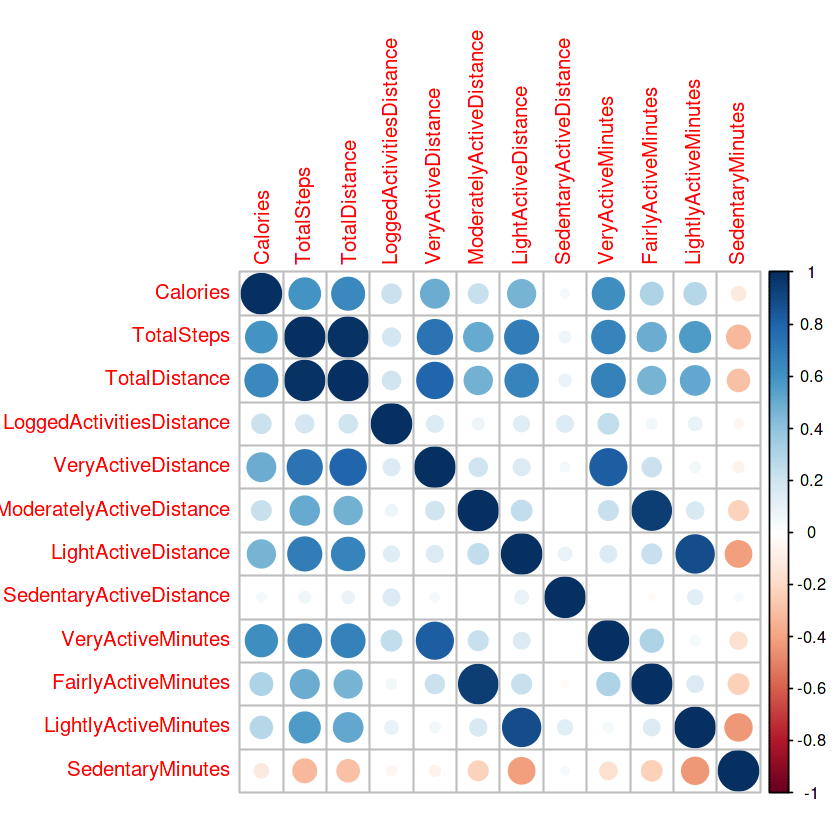

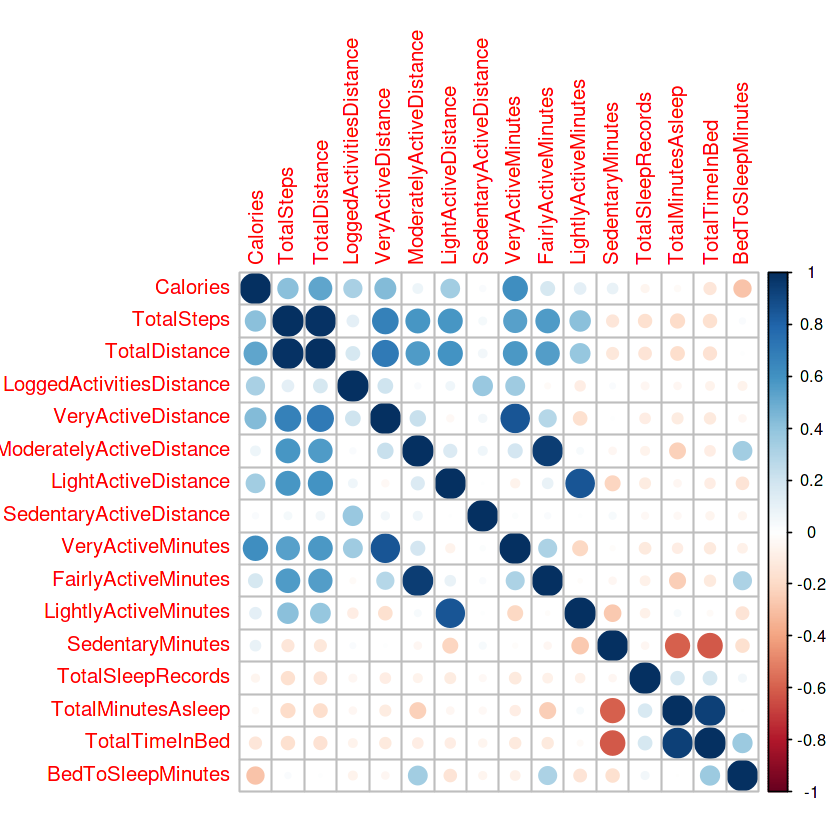

In [ ]:
# It's nice and all, but visualizing it with colors would be much better! Let's install corrplot and then visualize it
library(corrplot)
corrplot(cor(data_correlation)) #this is the complete data that did not drop any observations

# Here is the correlation matrix that includes the sleep variables
corrplot(cor(data_corr_withsleep))# this one removes the observations with "NA" which can affect the result

### It doesn't matter how intense, but how far
Based on the Correlation Plot, we can see that TotalSteps, TotalDistance (also with high correlation with TotalSteps, so they are basically the same variable), VeryActiveDistance, VeryActiveMinutes, and surprisingly, LightActiveDistance has a high positive correlation with Calories burned. We can surmised that as long as you walk greater distance or steps, it won't matter if it is intense or light activity.

SedentaryMinutes has a small negative effect on Calories burned.

Using the correlation matrix with additional sleep data shows that all sleep variables has low negative correlation on calories burned.

With that in mind, we will focus on these variables for our analysis, Calories, Distance, Steps, and Time (Daily/Hourly).

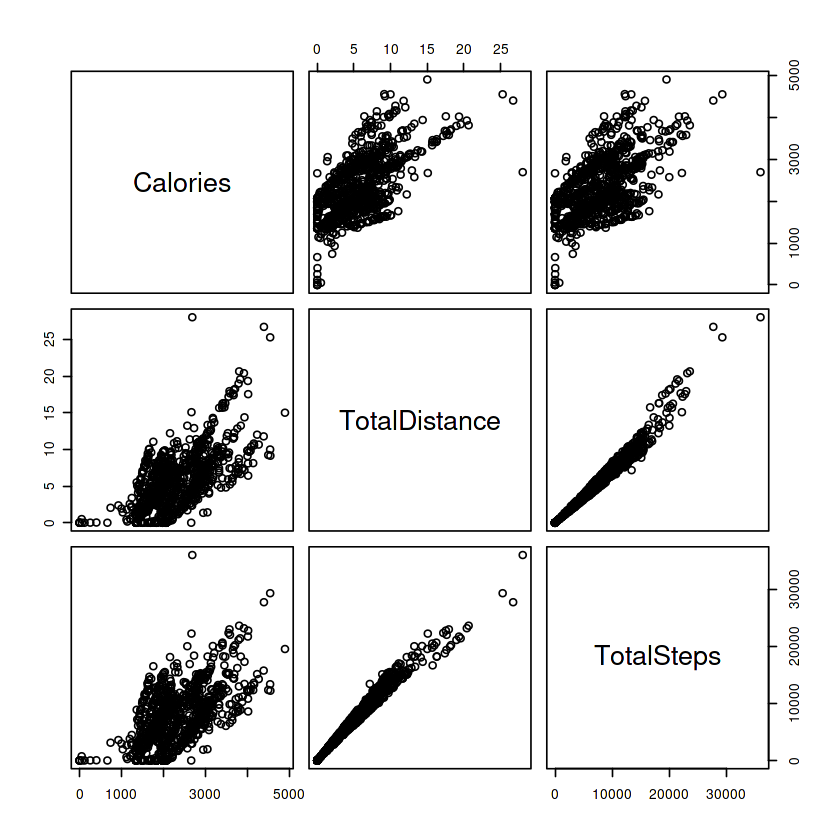

In [ ]:
# We will focus on this 3 variables
plot(select(data_correlation, Calories, TotalDistance, TotalSteps))

## Obligatory Graph
We already know from the correlation matrix above that Calories, Distance, and Steps have high correlation. But let's just add more graphs so our portfolio looks more cool and colorful. =)

### Distance and Steps vs. Calories


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



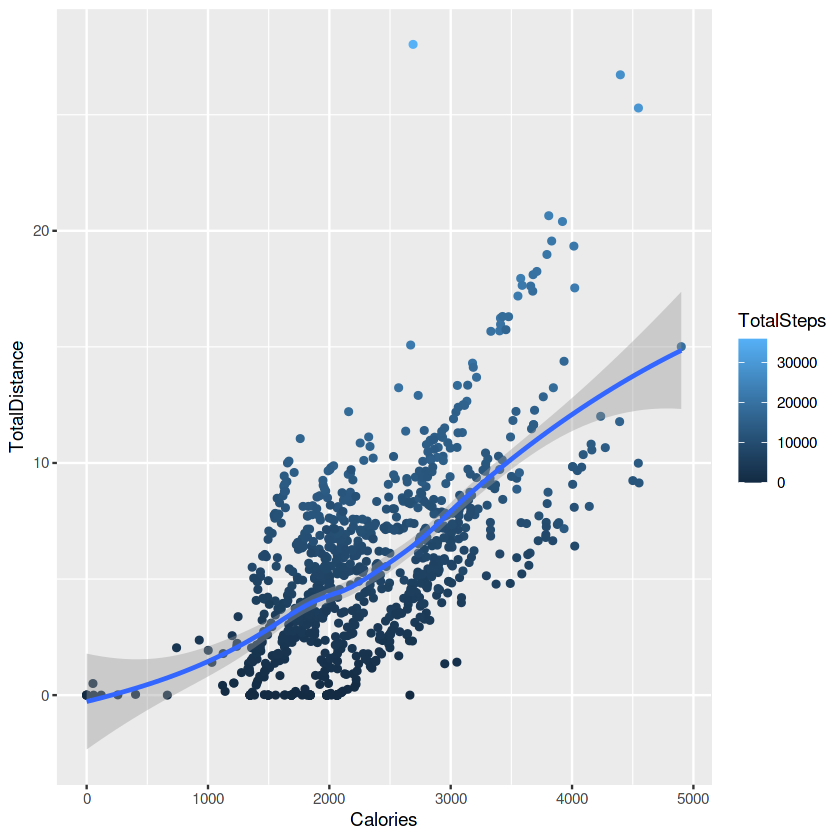

In [ ]:
# In here we made a graph showing the relationship of Calories burned with TotalDistance and TotalSteps
ggplot(data = merged_daily_activity, aes(x = Calories, y = TotalDistance, color = TotalSteps)) +
geom_point() +
geom_smooth()

### Sleep Variables has no effect on Calories

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 530 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 530 rows containing missing values (geom_point).”


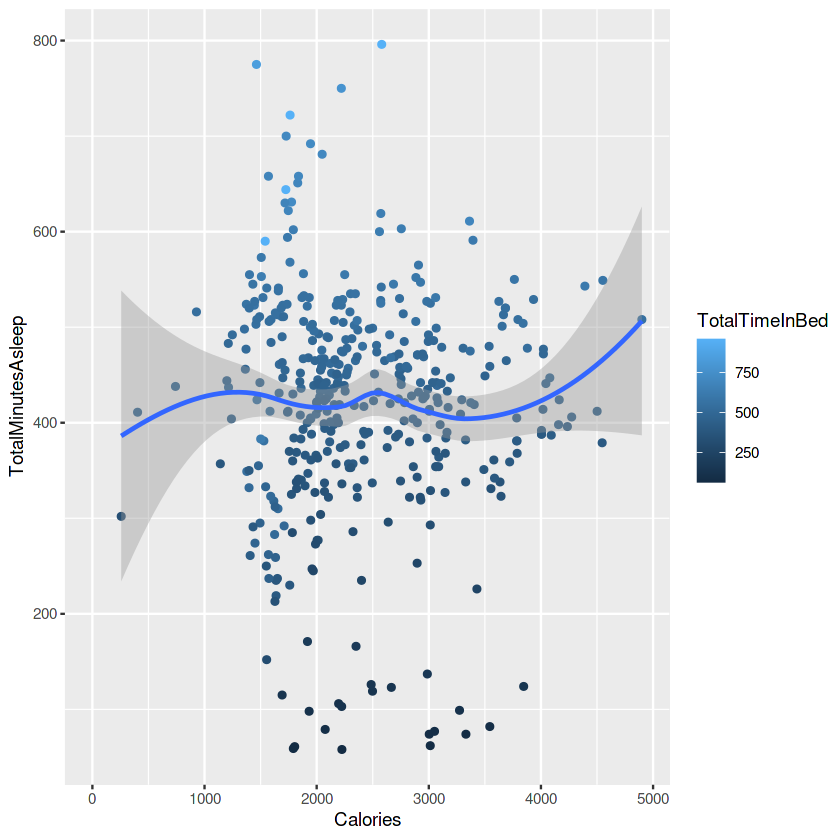

In [ ]:
ggplot(data = merged_daily_activity, aes(x = Calories, y = TotalMinutesAsleep, color = TotalTimeInBed)) +
geom_point() +
geom_smooth()

# Looking at the Warning messages below, notice how many records were removed when we join the Sleep variables

### Combining Calories, Activity, Sleep, and Weekday Variables
    Just flexing my data viz skill on how you can show 4 variables in one visualization.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



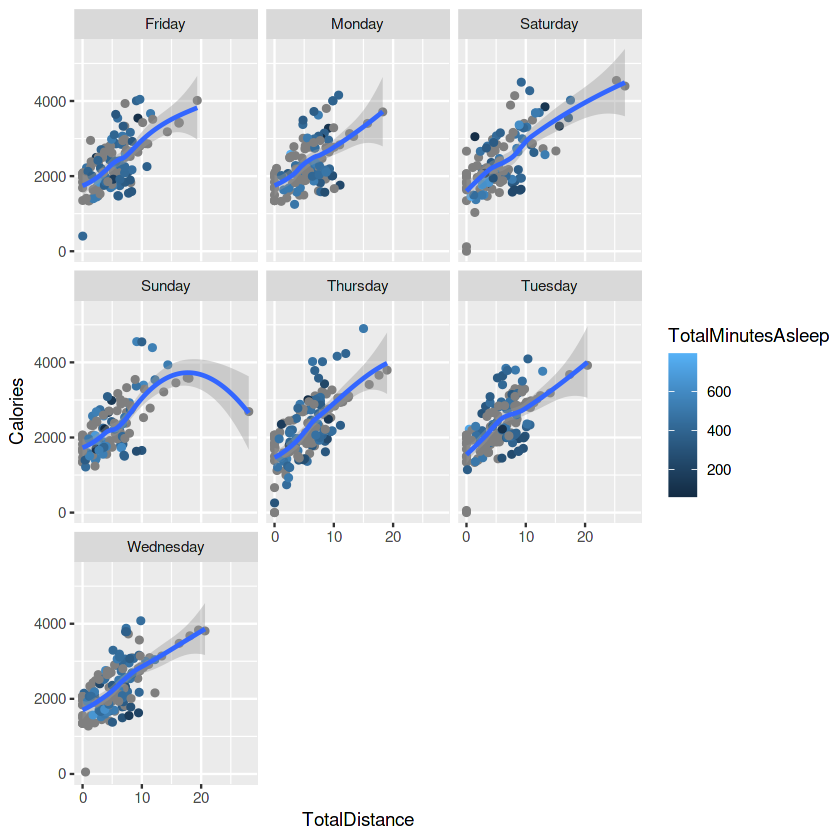

In [ ]:
# Let's check
ggplot(data = merged_daily_activity, aes(x = TotalDistance, y = Calories, color = TotalMinutesAsleep)) +
geom_point() +
geom_smooth() +
facet_wrap(~Weekday)

## Time to Analyze Time
### Using the Time Variable (Day and Hour)
Using the merged_daily_activity dataset. We will try to analyze the customer behavior per time variables like day of the week and hours.

In [ ]:
# Let's make a table that would summarize the data by Weekday using the Average of the following variables Distance and TotalMinutesAsleep
# Also demonstrate our "piping" skills while we're at it.

# Just like the previous case involving the correlation matrix, I have decided to create two datasets.
# one will include all the distance observation
avg_weekday_distance <- merged_daily_activity %>%
group_by(Weekday) %>%
summarise_at(c(AvgDistance = "TotalDistance", "TotalMinutesAsleep"), mean,na.rm = FALSE) # see how it produces an error because of the "NA" record

# and this one where we remove the "NA" from the sleep records
avg_weekday_sleep <- merged_daily_activity %>%
group_by(Weekday) %>%
summarise_at(c(AvgDistance = "TotalDistance", AvgSleepMinutes = "TotalMinutesAsleep"), mean,na.rm = TRUE)

# Check the created tables
glimpse(avg_weekday_distance)
glimpse(avg_weekday_sleep)

Rows: 7
Columns: 3
$ Weekday            <chr> "Friday", "Monday", "Saturday", "Sunday", "Thursday…
$ AvgDistance        <dbl> 5.309921, 5.588347, 5.901040, 5.027190, 5.326216, 5…
$ TotalMinutesAsleep <dbl> NA, NA, NA, NA, NA, NA, NA
Rows: 7
Columns: 3
$ Weekday         <chr> "Friday", "Monday", "Saturday", "Sunday", "Thursday", …
$ AvgDistance     <dbl> 5.309921, 5.588347, 5.901040, 5.027190, 5.326216, 5.83…
$ AvgSleepMinutes <dbl> 405.4211, 418.8298, 420.8103, 452.7455, 402.3692, 404.…


In [ ]:
# Before we even start graphing by Weekday, please note that graphing it as-is will show you a graph that arranges the Weekdays alphabetically
# In order to fix this we use this code from stack overflow

avg_weekday_distance <- mutate(avg_weekday_distance, Weekday= factor(Weekday, levels = c("Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")))
avg_weekday_sleep <- mutate(avg_weekday_sleep, Weekday= factor(Weekday, levels = c("Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")))

### Day of the Week Analysis
#### Active on Saturday and Tuesday
    Plotting the days of the week with distance (activity) we can see that Saturday recorded the most active day for our customer, followed by Tuesday. We know that Saturday is a weekend and most people have no work that day, so they probably have more time to exercise. Tuesday however, is puzzling and we need to dive deeper on what caused this sudden increase in activity.



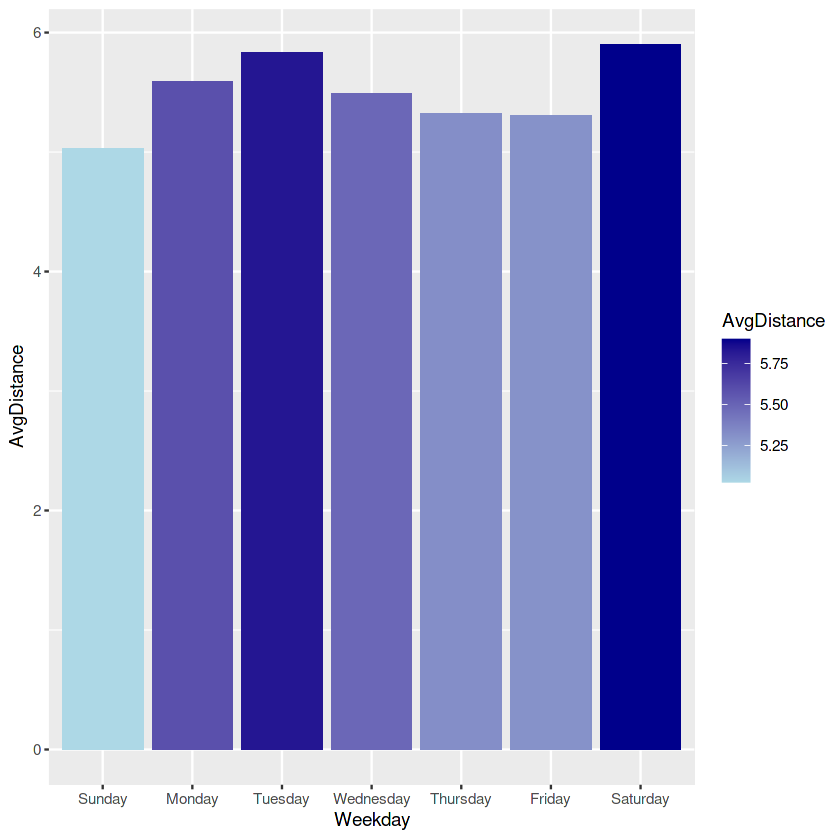

In [ ]:
ggplot(data = avg_weekday_distance, aes(x= Weekday, y = AvgDistance, fill = AvgDistance)) +
geom_bar(stat="identity") +
scale_fill_gradient (low="light blue", high= "dark blue")

#### Sunday the Real Rest Day
    It is shown that the participants, on average, sleeps between 6.67 hours and 7.5 hours. Sunday registered the highest number of sleep. Probably from all the intense activities (partying?) done on Saturday. Increased sleep on Wednesday also coincides with the increased activity shown on Tuesday. We are probably on to something with this.

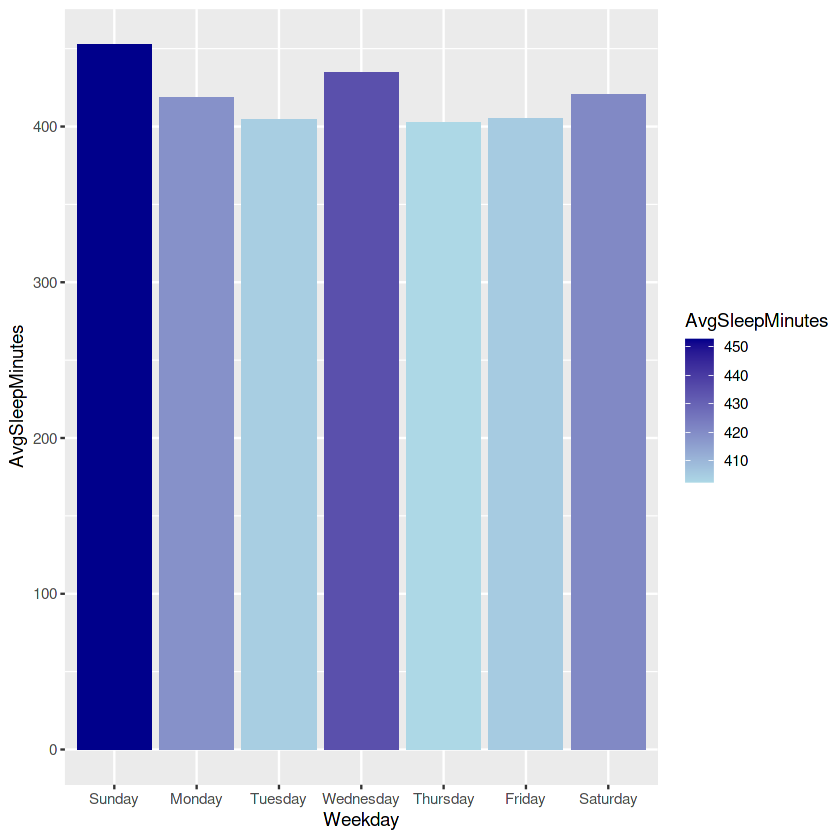

In [ ]:
ggplot(data = avg_weekday_sleep, aes(x= Weekday, y = AvgSleepMinutes, fill = AvgSleepMinutes)) +
geom_bar(stat="identity") +
scale_fill_gradient (low="light blue", high= "dark blue")

### The Hour Has Come
    We now analyze per hour data. This added granularity of our analysis will help us gain insight on the customers behavior per time of the day.
    
    Since we already determined that the distance travelled is the biggest contributor on burning calories, we will focus on the hourlySteps_merged.csv dataset (98% correlated to distance).

In [ ]:
# Preparing the table
hourly_steps <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv")

# checking the structure
str(hourly_steps)

# The ActivityHour column needs to have a consistent format
hourly_steps <- hourly_steps %>% mutate(ActivityHour = mdy_hms(ActivityHour))

# Next we add a Weekday and Hour column
hourly_steps <- hourly_steps %>% mutate(hourly_steps, Weekday=weekdays(ActivityHour)) %>%
    mutate(hourly_steps,TimeOfDay= format(ActivityHour, format = "%H"))

# When working on Weekday data, it is a good practive to keep them in order
hourly_steps <- mutate(hourly_steps, Weekday= factor(Weekday, levels = c("Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")))

# Let's check the transformation that we did
glimpse(hourly_steps)



'data.frame':	22099 obs. of  3 variables:
 $ Id          : num  1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
 $ ActivityHour: chr  "4/12/2016 12:00:00 AM" "4/12/2016 1:00:00 AM" "4/12/2016 2:00:00 AM" "4/12/2016 3:00:00 AM" ...
 $ StepTotal   : int  373 160 151 0 0 0 0 0 250 1864 ...
Rows: 22,099
Columns: 5
$ Id           <dbl> 1503960366, 1503960366, 1503960366, 1503960366, 150396036…
$ ActivityHour <dttm> 2016-04-12 00:00:00, 2016-04-12 01:00:00, 2016-04-12 02:…
$ StepTotal    <int> 373, 160, 151, 0, 0, 0, 0, 0, 250, 1864, 676, 360, 253, 2…
$ Weekday      <fct> Tuesday, Tuesday, Tuesday, Tuesday, Tuesday, Tuesday, Tue…
$ TimeOfDay    <chr> "00", "01", "02", "03", "04", "05", "06", "07", "08", "09…


In [ ]:
# Let's visualize our data using Heat Map

# But first, let us summarize the data
avg_hourly_steps_weekday <- hourly_steps %>%
group_by(Weekday, TimeOfDay) %>%
summarise(AvgSteps = mean(StepTotal))

# Check the table before plotting
glimpse(avg_hourly_steps_weekday)

steps_per_week<-avg_hourly_steps_weekday %>%
group_by(Weekday) %>%
summarise(StepsPerDay = sum(AvgSteps))

# Summarized average steps per week
steps_per_week

`summarise()` has grouped output by 'Weekday'. You can override using the
`.groups` argument.


Rows: 168
Columns: 3
Groups: Weekday [7]
$ Weekday   <fct> Sunday, Sunday, Sunday, Sunday, Sunday, Sunday, Sunday, Sund…
$ TimeOfDay <chr> "00", "01", "02", "03", "04", "05", "06", "07", "08", "09", …
$ AvgSteps  <dbl> 82.595041, 52.669421, 49.636364, 4.785124, 5.652893, 16.6859…


Weekday,StepsPerDay
<fct>,<dbl>
Sunday,6921.134
Monday,7754.952
Tuesday,8029.547
Wednesday,7580.110
Thursday,7865.223
Friday,7503.053
Saturday,8285.995


#### Time-Based Analysis
The heat map below will show you the average activity (steps) per hour per day

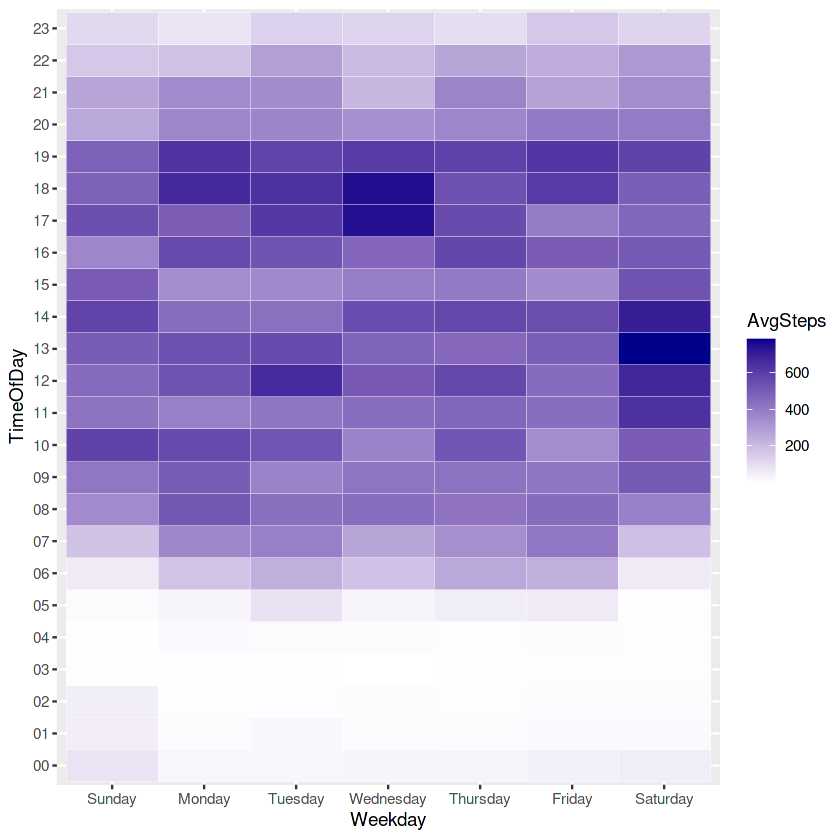

In [ ]:
# Heat Map using ggplot geom_tile
ggplot(avg_hourly_steps_weekday, aes(Weekday, TimeOfDay, fill = AvgSteps)) +
    geom_tile(color = "white") +
    scale_fill_gradient(low = "white", high = "dark blue")

That look's cool. How about we do it for the Sleep data. But upon checking the Fitabase tables, it looks like we only have it available per minute. Let's practice our data transformation skill again.

**Protip: copy-paste your code above and just modify it.**

In [ ]:
# Preparing the table
hourly_sleep <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv")

# checking the structure
str(hourly_sleep)
glimpse(hourly_sleep)

# The date column needs to have a consistent format
hourly_sleep <- hourly_sleep %>% mutate(date = mdy_hms(date))

# Next we add a Weekday and Hour column
hourly_sleep <- hourly_sleep %>% mutate(hourly_sleep, Weekday=weekdays(date)) %>%
    mutate(hourly_sleep,TimeOfDay= format(date, format = "%H")) %>%
    mutate(hourly_sleep,dateonly = format(date, format = "%m/%d/%y"))

# When working on Weekday data, it is a good practive to keep them in order
hourly_sleep <- mutate(hourly_sleep, Weekday= factor(Weekday, levels = c("Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")))

# Let's check the transformation that we did
glimpse(hourly_sleep)

# Since this data is per minute, we need to sum it up per hour
hourly_sleep_weekday <- hourly_sleep %>%
group_by(Id, dateonly, Weekday, TimeOfDay) %>%
summarise(MinSleep = sum(value))



'data.frame':	188521 obs. of  4 variables:
 $ Id   : num  1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
 $ date : chr  "4/12/2016 2:47:30 AM" "4/12/2016 2:48:30 AM" "4/12/2016 2:49:30 AM" "4/12/2016 2:50:30 AM" ...
 $ value: int  3 2 1 1 1 1 1 2 2 2 ...
 $ logId: num  1.14e+10 1.14e+10 1.14e+10 1.14e+10 1.14e+10 ...
Rows: 188,521
Columns: 4
$ Id    <dbl> 1503960366, 1503960366, 1503960366, 1503960366, 1503960366, 1503…
$ date  <chr> "4/12/2016 2:47:30 AM", "4/12/2016 2:48:30 AM", "4/12/2016 2:49:…
$ value <int> 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1…
$ logId <dbl> 11380564589, 11380564589, 11380564589, 11380564589, 11380564589,…
Rows: 188,521
Columns: 7
$ Id        <dbl> 1503960366, 1503960366, 1503960366, 1503960366, 1503960366, …
$ date      <dttm> 2016-04-12 02:47:30, 2016-04-12 02:48:30, 2016-04-12 02:49:…
$ value     <int> 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, …
$ logId     <dbl> 11380564589, 11380564589, 11380564589, 11380564589, 1138

`summarise()` has grouped output by 'Id', 'dateonly', 'Weekday'. You can
override using the `.groups` argument.


Checking the hourly sleep table we created

In [ ]:
# Check the table
hourly_sleep_weekday

# This is weird, how can a person sleep 77 minutes in one hour?

Id,dateonly,Weekday,TimeOfDay,MinSleep
<dbl>,<chr>,<fct>,<chr>,<int>
1503960366,04/12/16,Tuesday,02,25
1503960366,04/12/16,Tuesday,03,65
1503960366,04/12/16,Tuesday,04,61
1503960366,04/12/16,Tuesday,05,66
1503960366,04/12/16,Tuesday,06,60
1503960366,04/12/16,Tuesday,07,61
1503960366,04/12/16,Tuesday,08,33
1503960366,04/13/16,Wednesday,03,61
1503960366,04/13/16,Wednesday,04,60


##### How can you sleep for more than 60 minutes in one hour?
Woah! Did you see that? How can a person sleep for 77 minutes in one hour?
Unless the participant has a time-dilation device, which is highly unlikely, we will assume that there is a data quality issue here. Upon checking the file in Excel, we have values of more than 1 in a one minute range. We need to transform those values to 1 before doing a rerun or just count the rows with values.

In [ ]:
# We modify the group by using count
hourly_sleep_weekday <- hourly_sleep %>%
group_by(Id, dateonly, Weekday, TimeOfDay) %>%
summarise(MinSleep = n())

#Then check again
hourly_sleep_weekday

`summarise()` has grouped output by 'Id', 'dateonly', 'Weekday'. You can
override using the `.groups` argument.


Id,dateonly,Weekday,TimeOfDay,MinSleep
<dbl>,<chr>,<fct>,<chr>,<int>
1503960366,04/12/16,Tuesday,02,13
1503960366,04/12/16,Tuesday,03,60
1503960366,04/12/16,Tuesday,04,60
1503960366,04/12/16,Tuesday,05,60
1503960366,04/12/16,Tuesday,06,60
1503960366,04/12/16,Tuesday,07,60
1503960366,04/12/16,Tuesday,08,33
1503960366,04/13/16,Wednesday,03,52
1503960366,04/13/16,Wednesday,04,60


Much better! now we run a script to group it by Weekday. Then create a Time-Based Heat Map for Sleep.

`summarise()` has grouped output by 'Weekday'. You can override using the
`.groups` argument.


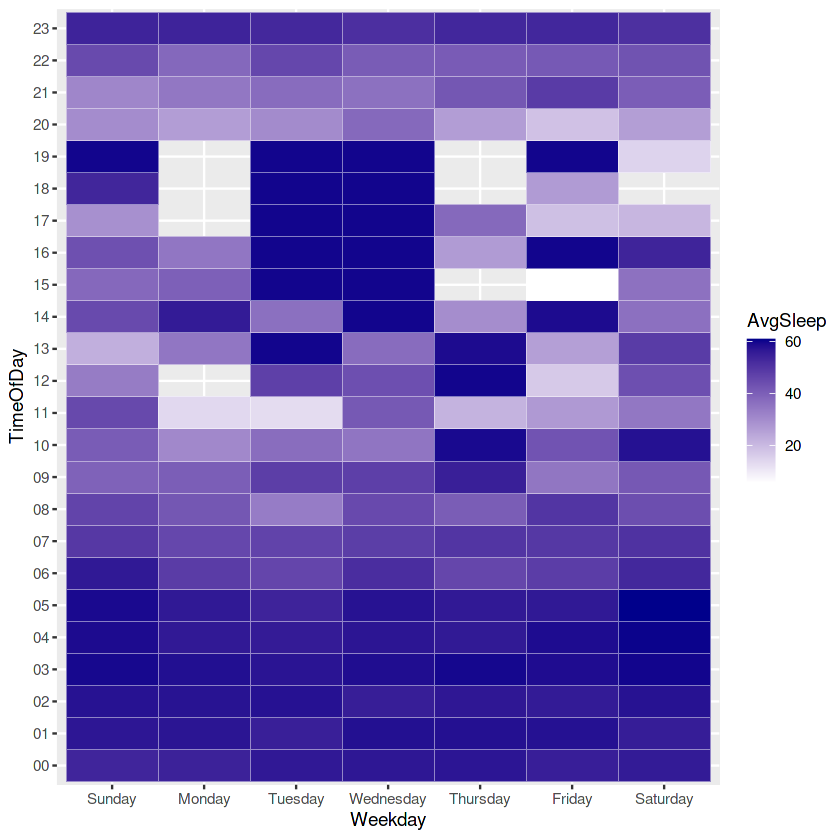

In [ ]:
# Summarize the data per Weekday, per TimeOfDay
avg_hourly_sleep_weekday <- hourly_sleep_weekday %>%
group_by(Weekday, TimeOfDay) %>%
summarise(AvgSleep = mean(MinSleep))

ggplot(avg_hourly_sleep_weekday, aes(Weekday, TimeOfDay, fill = AvgSleep)) +
    geom_tile(color = "white") +
    scale_fill_gradient(low = "white", high = "dark blue")

There are a lot of null fields in our heat map, this could mean any of the following:
1. the wearer removed the device at that time
2. the device stopped recording because:

 a. low-battery or charging

 b. turned off the feature / set by user
    
    
It also shows that there are a lot of recorded sleeping time by 1:00 PM to 7:00PM. We guessed that the user removed the device at that time and the device assumed that the user is sleeping. Who would sleep at that time range?

Another explanation would be the time is not set properly on the device. It may have been set as PM instead of AM.

With the data quality issue seen, and based on our analysis, the sleep data would not be a suitable variable to use because it could be misleading.

## Check User Profile
### There are only 33 distinct users, why not check their profile?
Why not?

`summarise()` has grouped output by 'Id', 'date'. You can override using the
`.groups` argument.


Id,date,Weekday,AvgStep,AvgDist,AvgCal,AvgActMin,AvgFActMin,AvgLActMin,AveSedMin
<dbl>,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1503960366,2016-04-12,Tuesday,13162,8.50,1985,25,13,328,728
1503960366,2016-04-13,Wednesday,10735,6.97,1797,21,19,217,776
1503960366,2016-04-14,Thursday,10460,6.74,1776,30,11,181,1218
1503960366,2016-04-15,Friday,9762,6.28,1745,29,34,209,726
1503960366,2016-04-16,Saturday,12669,8.16,1863,36,10,221,773
1503960366,2016-04-17,Sunday,9705,6.48,1728,38,20,164,539


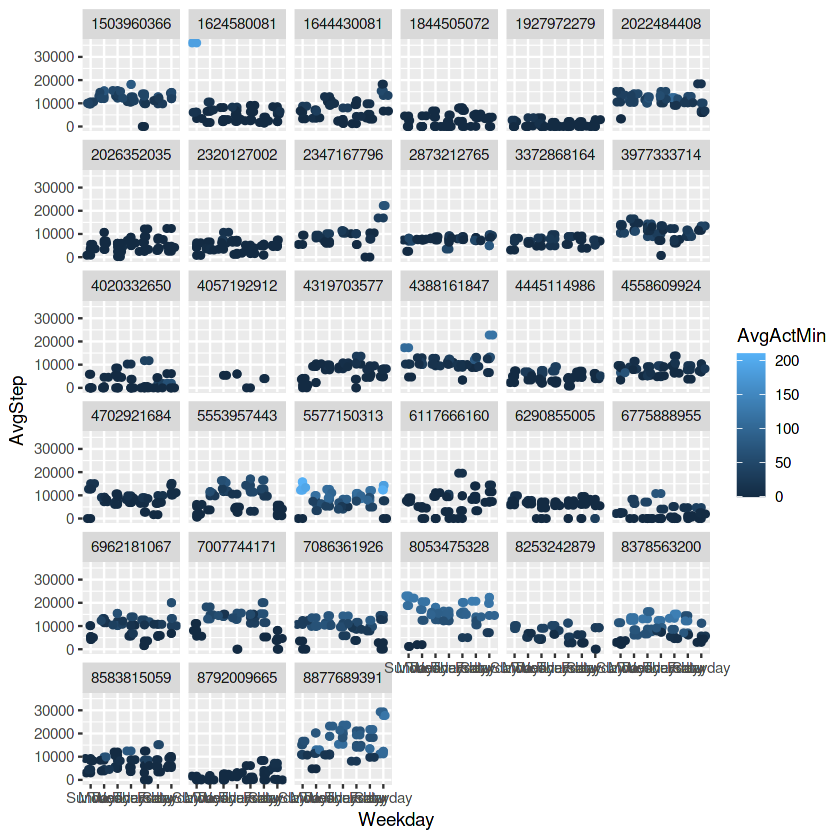

In [ ]:
# Create a profile per user.

group_user <- merged_daily_activity %>%
group_by(Id, date, Weekday) %>%
summarise(AvgStep = mean(TotalSteps), AvgDist = mean(TotalDistance), AvgCal = mean(Calories), AvgActMin = mean(VeryActiveMinutes), AvgFActMin = mean(FairlyActiveMinutes), AvgLActMin = mean(LightlyActiveMinutes), AveSedMin = mean(SedentaryMinutes))

# Keep the Weekday in order
group_user <- mutate(group_user, Weekday= factor(Weekday, levels = c("Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")))
head(group_user)

ggplot(data=group_user, aes(x=Weekday, y=AvgStep, color = AvgActMin)) + geom_point() + geom_jitter() + facet_wrap(~Id)
# You can use the group_user dataset for clustering. I will refresh my memory first how to do it.
# I'll leave this comment as reminder to do a cluster analysis on the users.

As seen from the user profile, there are outliers in terms of activity on a given day. Those particular users may have participated on a marathon event, hiking, cycling, etc. So a caveat is needed when using average as an indicator for aggregating the usage of the device. The extremes might pull the data and affect the average.

One user only has 4 data points, and we should have probably removed that user from the observation. Oh! hindsight! Will fix this on the next version.

### We will try to do a Cluster Analysis Using K-Means

Heavily borrowed the scripts [here](https://www.youtube.com/watch?v=NKQpVU1LTm8)

In [ ]:
# Trying out k-means clustering
# Library for fviz_cluster function

library(factoextra)



Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



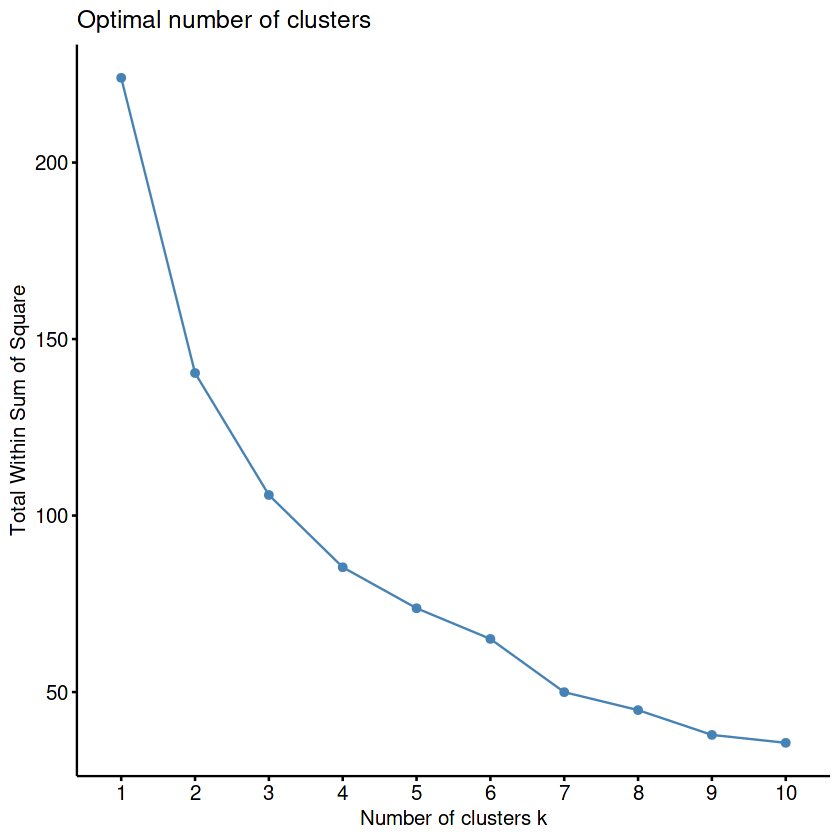

,AvgStep,AvgDist,AvgCal,AvgActMin,AvgFActMin,AvgLActMin,AvgSedMin
1503960366,1.28262163,0.86631062,-0.82738810,0.76818292,0.48266584,0.37286095,-0.6620090
1624580081,-0.49833546,-0.53696965,-1.41740891,-0.48861607,-0.61750002,-0.50369947,1.1355158
1644430081,-0.06822792,-0.03958810,0.93503407,-0.45140258,0.66434379,-0.17415247,0.7147484
1844505072,-1.38250361,-1.33275067,-1.25774613,-0.84635155,-0.98953679,-1.00538138,0.9111261
1927972279,-1.84750795,-1.71884452,-0.19605154,-0.79640358,-1.03205528,-2.01938307,1.3974219
2022484408,1.07411701,0.96521665,0.40122667,0.66693703,0.49861027,0.86773462,0.4984471
2026352035,-0.54780899,-0.70270409,-1.31591962,-0.84770149,-1.07457376,0.85709675,-1.3586791
2320127002,-0.78535047,-0.79893701,-0.99082243,-0.79505363,-0.88324057,0.08606399,0.9703027
2347167796,0.55684152,0.34240175,-0.42521518,-0.28679926,0.59752481,0.80241810,-1.3685655
2873212765,0.00801102,-0.10938410,-0.64926753,-0.26182527,-0.59092597,1.53451626,0.4309178


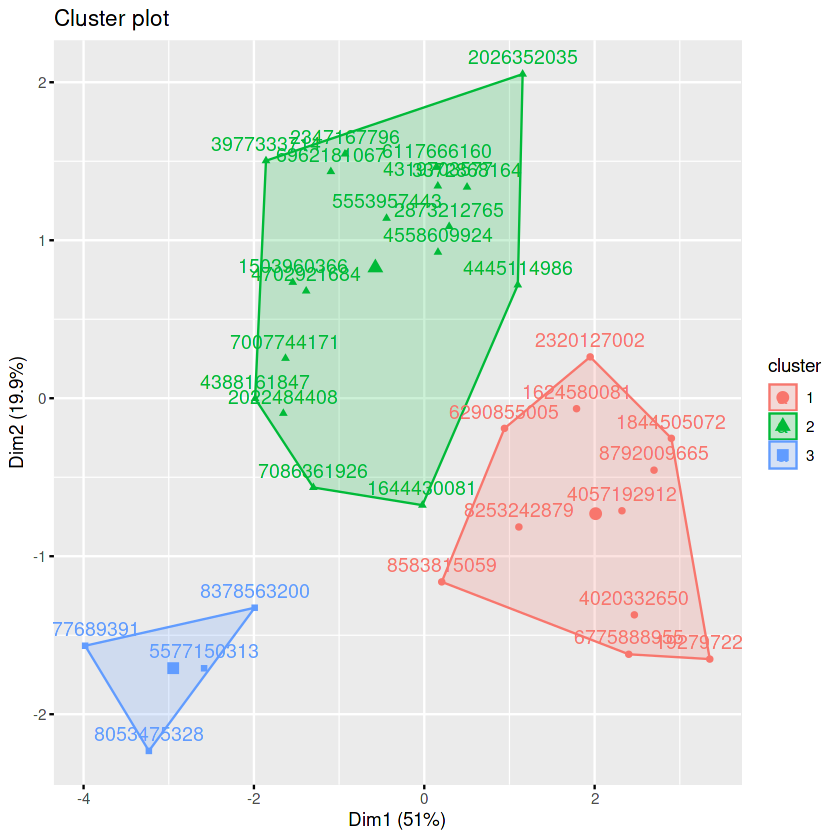

In [ ]:
# Creating a subset of the group_user data for our k-means clustering
# Get only the numerical values, we will group the data points per user id
user_data <- merged_daily_activity %>%
group_by(Id) %>%
summarise(AvgStep = mean(TotalSteps), AvgDist = mean(TotalDistance), AvgCal = mean(Calories), AvgActMin = mean(VeryActiveMinutes), AvgFActMin = mean(FairlyActiveMinutes), AvgLActMin = mean(LightlyActiveMinutes), AvgSedMin = mean(SedentaryMinutes))

# Convert the Id column to string
user_data <- mutate(user_data, Id = as.character(Id))

# Scale the data, remove the Id column, kmeans will treat it as a numerical data
user_data_scaled <- scale(select(user_data, -Id))

# Determine how many clusters we can make
fviz_nbclust(user_data_scaled, kmeans, method = "wss")

# We will try to use 3 clusters to group these users for simplicity
km <- kmeans(user_data_scaled, centers = 3, nstart = 69)
km_cluster <- km$cluster

# Add back the Id as row names
rownames(user_data_scaled) <- paste(user_data$Id)

# Visualize It
fviz_cluster(km, data = user_data_scaled)

user_data_scaled

When you check the Id profile of the user to their activity graphs and tables above. We can deduce how the clustering was performed.
The left part of the graph seems to indicate users with higher average steps, while the right part took lower average steps. The lower part indicates higher number of active minutes, while the upper part indicates lower number of active minutes.

The blue cluster (cluster 3) were the most active users of the product.

The green cluster (cluster 2) were the moderate/casual users of the product.

The red cluster (cluster 1) were the most likely to be sedentary users.

In [ ]:
# To view how we clustered each user id
table(km_cluster, user_data$Id)
# Add a cluster to the user_data_table. Not working properly yet. Will find solution soon.
#km.cluster <- data.frame(cbind(km$cluster))
#head(km.cluster)
#user_data_scaled$cluster <- km.cluster$cbind.km.cluster.
#user_data_scaled

          
km_cluster 1503960366 1624580081 1644430081 1844505072 1927972279 2022484408
         1          0          1          0          1          1          0
         2          1          0          1          0          0          1
         3          0          0          0          0          0          0
          
km_cluster 2026352035 2320127002 2347167796 2873212765 3372868164 3977333714
         1          0          1          0          0          0          0
         2          1          0          1          1          1          1
         3          0          0          0          0          0          0
          
km_cluster 4020332650 4057192912 4319703577 4388161847 4445114986 4558609924
         1          1          1          0          0          0          0
         2          0          0          1          1          1          1
         3          0          0          0          0          0          0
          
km_cluster 4702921684 5553957443

#### We created 3 clusters
Each clusters would represent the type of users that we have. We can formulate different marketing strategies per type of clusters.



# Act

Based on the insights presented above. We have formulated these following recommendations:

## Walk it Off
### Not the Intensity, but the Distance
If the goal of the user is to stay healthy (by losing weight/calories). We can say that walking is highly encouraged. It doesn't even matter if it's brisk walking, walking the stairs, or treadmill. As long as you walk. Our analysis shows that even LightActiveDistance have a strong relationship with Calories burned.

We recommend to add a feature on the device where the user can set a goal on the minimum number of steps per day. Having a goal can motivate the user to perform better to achieve their daily objective.

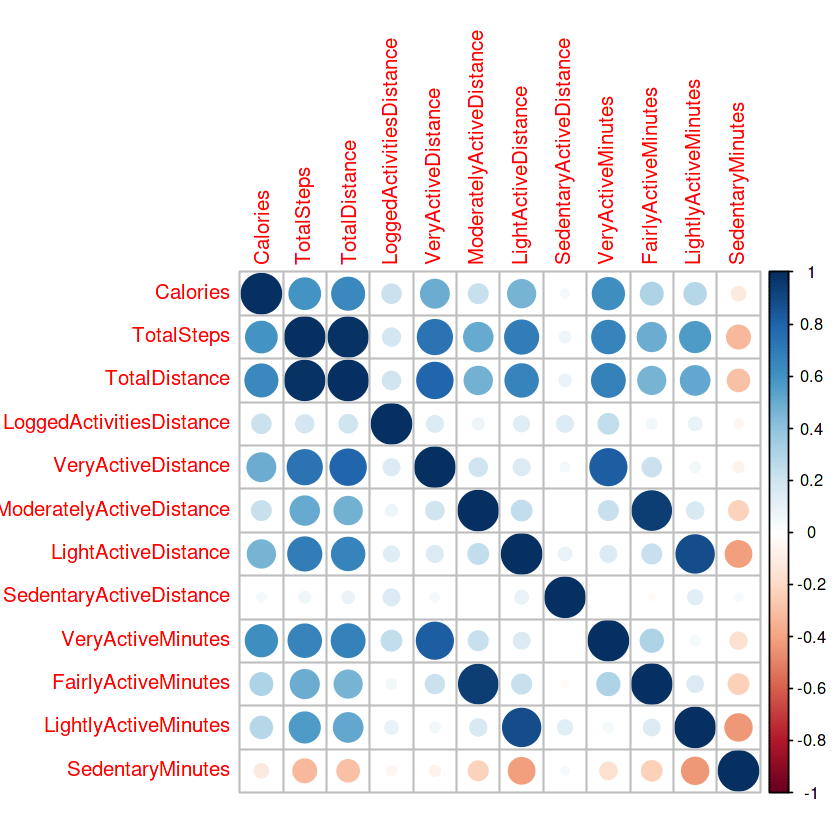

In [ ]:
library(corrplot)
corrplot(cor(data_correlation))

## Need more data to get user behavior about Sleep
Only 24 out of 33 participants have sleep data, which is 7 out of 10 who cared to have their sleep data recorded.
Even with those number of participants, there are still issues with the recording of data, there are a lot of times that observations are missing. The device might be removed during sleep, on shower, charging the device, etc. We also note that there is a high value of sleep data recorded during 1:00PM - 7:00PM which might be erroneous due to the setting of AM and PM.

With that we recommend that the company gather more data to get any meaningful insight from the users' sleeping patterns. The result of our analysis shows that sleep has no strong correlation or effect on the user's activity.

We would also like to warn those who would use the Sleep dataset to get insight. There are quality issues with the sleep data and might lead them to a wrong analysis.

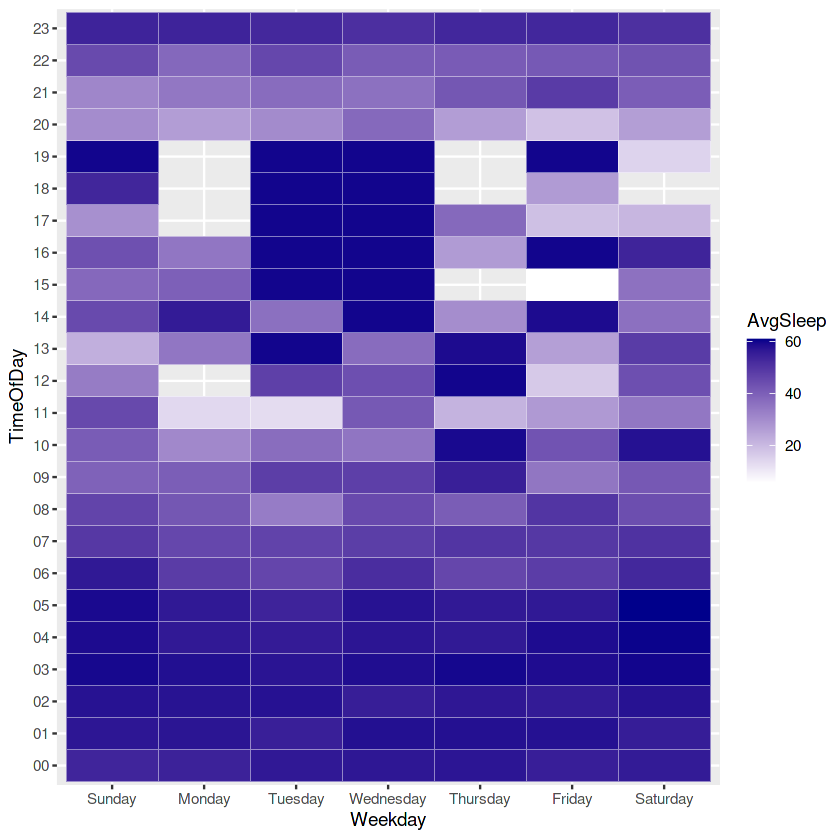

In [ ]:
#A lot of missing data
ggplot(avg_hourly_sleep_weekday, aes(Weekday, TimeOfDay, fill = AvgSleep)) +
    geom_tile(color = "white") +
    scale_fill_gradient(low = "white", high = "dark blue")

## Marketing Strategy

A health device that monitors the users Activity would be useful for the health buffs. So we recommend to continue advertising it as a supplement for users who wish to have an active lifestyle. It would have been helpful if the company provided an age range field of the users, so we can get insight on which age range were the most active.

### Weekend Warriors
With the available data and limited observation on time of use, we can see that Saturday is the most active day of the week. Which means that the most active users were most likely workers that can get really active on weekend. The company can target the demographics of workers, techies, and health conscious people.

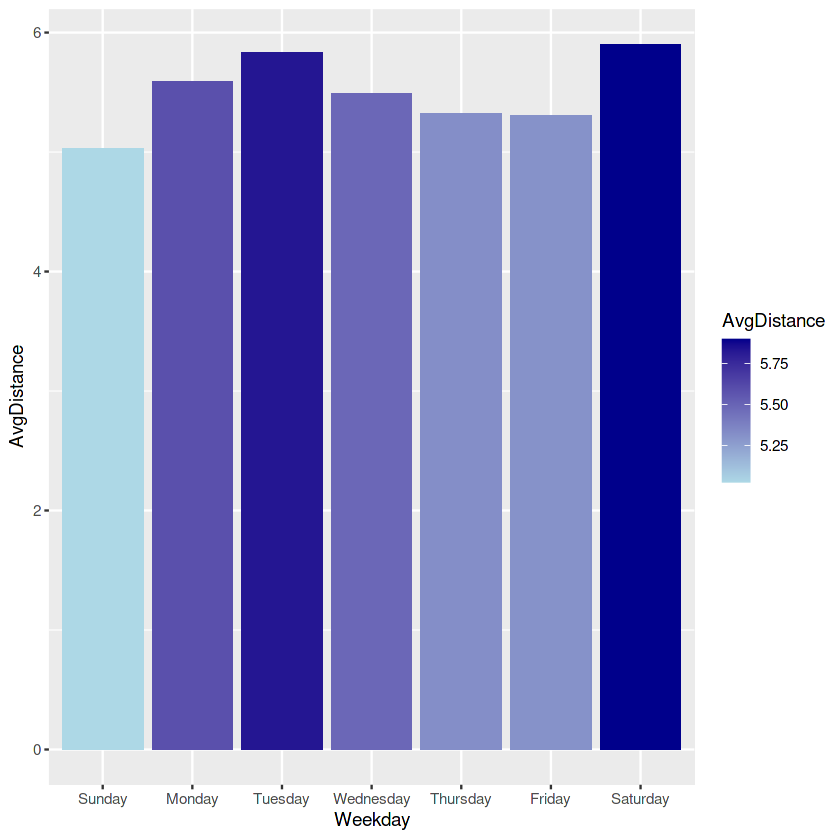

In [ ]:
ggplot(data = avg_weekday_distance, aes(x= Weekday, y = AvgDistance, fill = AvgDistance)) +
geom_bar(stat="identity") +
scale_fill_gradient (low="light blue", high= "dark blue")

## Customize Exercise Regimen per User Type (Cluster)
Using cluster analysis, Bellabeat now has an insight on the different type of users that they have. We recommend on taking a customized approach on motivating the different type of users to exercise.

* Cluster 3, being the most active need no further motivation, but a quick reminder from a device if this users became sedentary for a long period would be a good way to get them back on their feet.

* Cluster 2, the moderate/casual users; giving them a daily goal on number of steps might motivate them to be more active. Remind them, based on analysis, that they don't necessarily need to do an intense workout as a normal walk would suffice. Again, it's not the intensity, but the steps and distance that matter in burning calories.

* Cluster 1, the sedentary users; they probably bought this device to motivate themselves to be more active, or someone simply gave them as a gift. In any case, a reminder on the health risks of a sedentary lifestyle might push them off their couch.

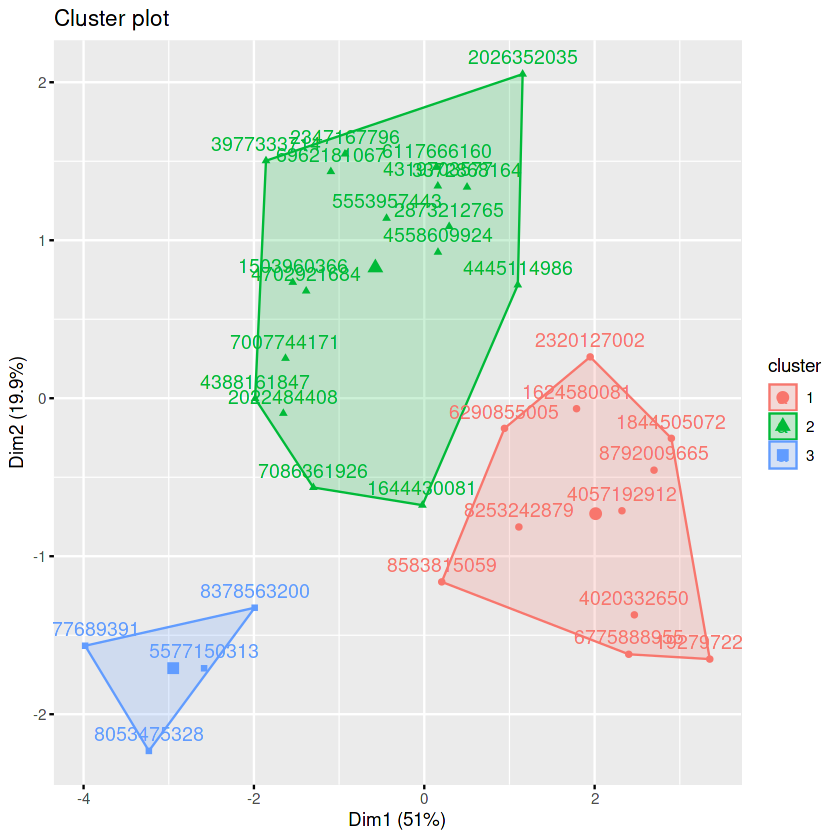

In [ ]:
fviz_cluster(km, data = user_data_scaled)

# But Wait There's More
## Let's perform a deep dive analysis

I got curious about the heartrate_seconds_merged.csv dataset. Might as well analyze it.

In [ ]:
# pulling the data from a csv table
heartrate_per_second <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv")

'data.frame':	2483658 obs. of  3 variables:
 $ Id   : num  2.02e+09 2.02e+09 2.02e+09 2.02e+09 2.02e+09 ...
 $ Time : chr  "4/12/2016 7:21:00 AM" "4/12/2016 7:21:05 AM" "4/12/2016 7:21:10 AM" "4/12/2016 7:21:20 AM" ...
 $ Value: int  97 102 105 103 101 95 91 93 94 93 ...


       Id                 Time                         Value       
 Min.   :2.022e+09   Min.   :2016-04-12 00:00:00   Min.   : 36.00  
 1st Qu.:4.388e+09   1st Qu.:2016-04-19 06:18:10   1st Qu.: 63.00  
 Median :5.554e+09   Median :2016-04-26 20:28:50   Median : 73.00  
 Mean   :5.514e+09   Mean   :2016-04-26 19:43:52   Mean   : 77.33  
 3rd Qu.:6.962e+09   3rd Qu.:2016-05-04 08:00:20   3rd Qu.: 88.00  
 Max.   :8.878e+09   Max.   :2016-05-12 16:20:00   Max.   :203.00  
   Weekday           TimeOfDay           dateonly        
 Length:2483658     Length:2483658     Length:2483658    
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         

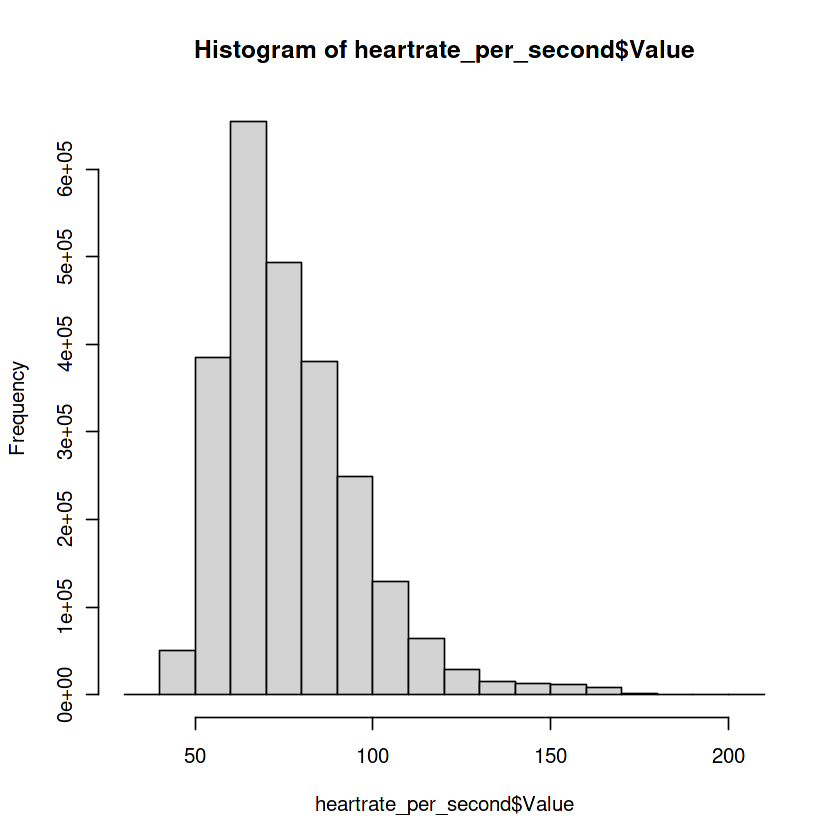

In [ ]:
# check the structure of the table
str(heartrate_per_second)

# Fix the datetime field
heartrate_per_second <- heartrate_per_second %>% mutate(Time = mdy_hms(Time))

heartrate_per_second <- heartrate_per_second %>% mutate(heartrate_per_second, Weekday=weekdays(Time)) %>%
    mutate(heartrate_per_second,TimeOfDay= format(Time, format = "%H")) %>%
    mutate(heartrate_per_second,dateonly = format(Time, format = "%m/%d/%y"))

# Summary Statistics
summary(heartrate_per_second)
hist(heartrate_per_second$Value)

There are observations with more than 200 heart beats per minute (BPM). Even on an intense activity a BPM of more than 200 is dangerous.
Let's check those record with more than 200 BPM.

Additional resource on the maximum BPM can be found [here](https://www.healthline.com/health/running-heart-rate#ideal-rate). It tells us that 200BPM can be normal for a 20-year-old, but if the user is 30 or above, it might mean a problem.

In [ ]:
# Let's check how far is 200BPM from the normal range
sd(heartrate_per_second$Value)

[1] 19.4045

With a standard deviation of 19.4, and a mean of 77.3, we can say that the 200 BPM is more than 6 standard deviation away from the mean. Which is really, really far from the norm, about 99.99966%. In 6 Sigma lingo, this event could only happen 3.4 times per 1,000,000 observations. This means this user is experiencing an extraordinary event. They could be experiencing palpitation from having too much coffee, an anxiety attack, or other medical condition.

In [ ]:
heartrateBPM <- heartrate_per_second %>% filter(Value >= 200)
heartrateBPM

Id,Time,Value,Weekday,TimeOfDay,dateonly
<dbl>,<dttm>,<int>,<chr>,<chr>,<chr>
2022484408,2016-04-21 16:31:20,200,Thursday,16,04/21/16
2022484408,2016-04-21 16:31:30,202,Thursday,16,04/21/16
2022484408,2016-04-21 16:31:40,203,Thursday,16,04/21/16
2022484408,2016-04-21 16:31:50,202,Thursday,16,04/21/16
2022484408,2016-04-21 16:32:00,203,Thursday,16,04/21/16
2022484408,2016-04-21 16:32:10,203,Thursday,16,04/21/16
2022484408,2016-04-21 16:32:20,203,Thursday,16,04/21/16
2022484408,2016-04-21 16:32:35,203,Thursday,16,04/21/16
2022484408,2016-04-21 16:32:40,201,Thursday,16,04/21/16


The event happened on a Thursday between 4:31 PM - 5:06 PM.

       Id                 Time                         Value       
 Min.   :2.022e+09   Min.   :2016-04-12 07:21:00   Min.   : 38.00  
 1st Qu.:2.022e+09   1st Qu.:2016-04-19 17:55:18   1st Qu.: 68.00  
 Median :2.022e+09   Median :2016-04-27 15:37:22   Median : 76.00  
 Mean   :2.022e+09   Mean   :2016-04-27 08:29:35   Mean   : 80.24  
 3rd Qu.:2.022e+09   3rd Qu.:2016-05-04 14:10:57   3rd Qu.: 89.00  
 Max.   :2.022e+09   Max.   :2016-05-12 15:48:05   Max.   :203.00  
   Weekday           TimeOfDay           dateonly        
 Length:154104      Length:154104      Length:154104     
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         

[1] 17.59559

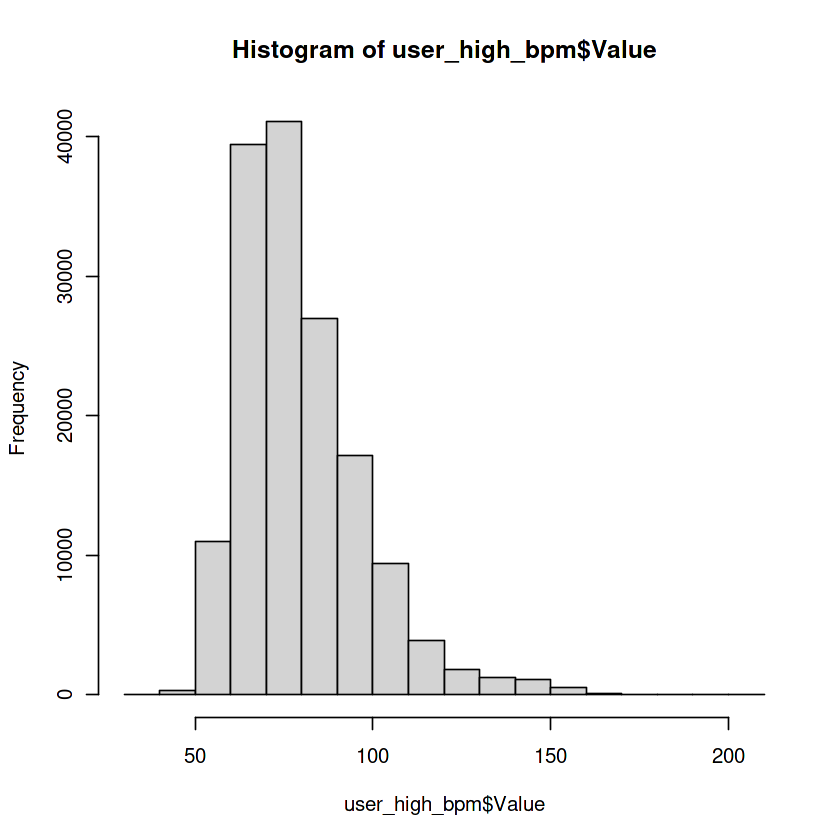

In [ ]:
# Let's check this user
user_high_bpm <- heartrate_per_second %>% filter(Id == 2022484408)
summary(user_high_bpm)
hist(user_high_bpm$Value)
sd(user_high_bpm$Value)

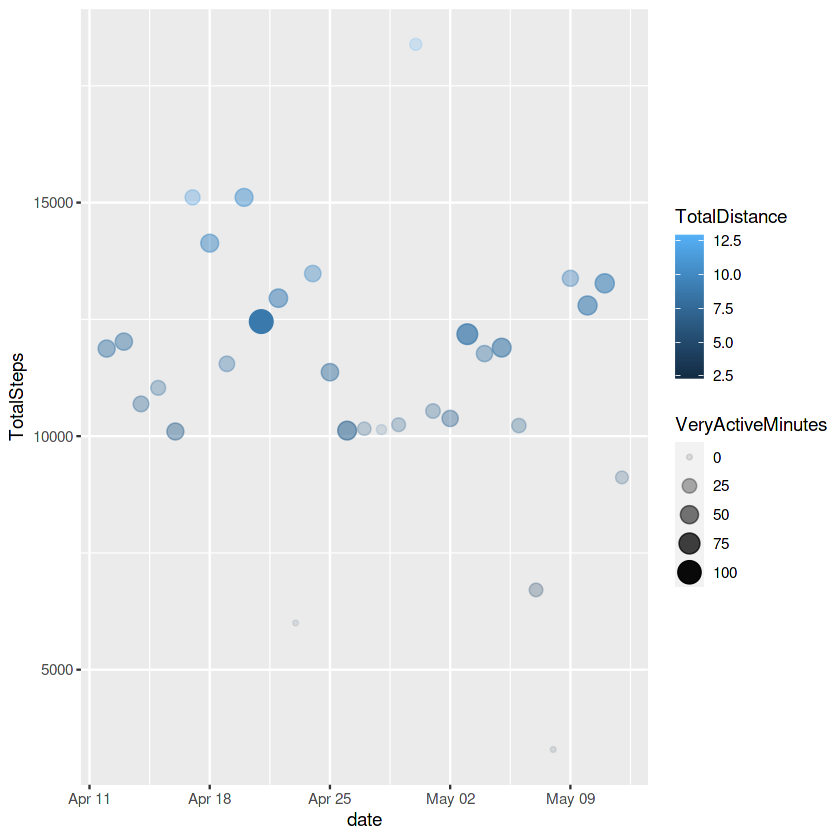

In [ ]:
# Checking his behavior from previous dataset.
check_user <- merged_daily_activity %>% filter(Id == 2022484408)

ggplot(data=check_user, aes(x = date, y = TotalSteps, size = VeryActiveMinutes, alpha = VeryActiveMinutes, color = TotalDistance)) + geom_point()

On the day of April 21, where the user recorded a 200BPM, it also recorded an unusually high VeryActiveMinutes.
Questions for future clarification:
* Given the unusually high VeryActiveMinutes that time, is the data then valid with 200BPM?
* If there is an intense activity that time, why is the total step and total distance in a normal range? Did they jump in place? Wasn't it recorded? Should the steps and distance be higher with an intense activity?
* If what happened is a palpitation? Why was it recorded under VeryActiveMinutes?

Their normal heartbeat is 80BPM, with a standard deviation of 17.6. Their recorded 200BPM is 6.8 sigma away from the mean. This means the event that transpired on 4/21/2016 between 16:31 and 15:06 is an extraordinary event, less than 3 occurence out of a million.
The device can be used to alert the user of an extreme event based on BPM. This functionality would be useful during emergency. If the user suffer a palpitation, stroke, or hypertension, the device can alert the user or their contacts in case of emergency.